In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

In [3]:
colab_flag = False

FTYPE = np.float32
ITYPE = np.int32

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/Kolmogorov


In [7]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if gpus:
        gpu_to_use = 0
        tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
        logical_devices = tf.config.list_logical_devices('GPU')
        print(logical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2023-02-15 13:08:29.362213: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-15 13:08:29.362721: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-15 13:08:29.421507: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-15 13:08:29.421831: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-15 13:08:29.422181: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [8]:
from tools.misc_tools import create_data_for_RNN, mytimecallback, SaveLosses, plot_losses, readAndReturnLossHistories
from tools.ae_v1 import Autoencoder
from tools.ESN_v1_AR import ESN

In [9]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print(tf.config.list_logical_devices())
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]
2.8.1


# KS System

In [10]:
# setting up params (and saving, if applicable)
from numpy import *

# RNN directory
dir_name_rnn = os.getcwd()+'/saved_ESN/ESN_001'

# reading AE directory
with open(dir_name_rnn + '/sim_data_AE_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))

# 'params_mat',
# 'init_state_mat',
# 't0',
# 'T',
# 'delta_t',
# 'return_params_arr',
# 'dir_name_ae',
# 'normalize_dataset',
# 'stddev_multiplier',
# 'use_ae_data'

dir_name_ae = params_dict['dir_name_ae']
ae_idx = dir_name_ae[-3:]
dir_name_ae = os.getcwd()+'/saved_ae/ae_'+ae_idx

try:
    use_ae_data = params_dict['use_ae_data']
except:
    print("'use_ae_data' not present in sim_data_AE_params, set to None.")
    use_ae_data = None

# reading RNN paramaters
with open(dir_name_rnn + '/RNN_specific_data.txt') as f:
    lines = f.readlines()

params_rnn_dict = eval(''.join(lines))

#- 'dt_rnn':dt_rnn,
#- 'T_sample_input':T_sample_input,
#- 'T_sample_output':T_sample_output,
#- 'T_offset':T_offset,
# 'boundary_idx_arr':boundary_idx_arr,
# 'delta_t':delta_t,
#- 'params':params,
#- 'return_params_arr':return_params_arr,
#- 'normalize_dataset':normalize_dataset,
# 'num_input_tsteps':num_input_tsteps,
# 'stddev_multiplier':stddev_multiplier,
# 'skip_intermediate':skip_intermediate,
# 'module':ESN.__module__,
# 'noise_type':noise_type,
#- 'normalization_type':normalization_type,

dt_rnn = params_rnn_dict['dt_rnn']
# T_sample_input = params_rnn_dict['T_sample_input']
# T_sample_output = params_rnn_dict['T_sample_output']
# T_offset = params_rnn_dict['T_offset']
# return_params_arr = params_rnn_dict['return_params_arr']
try:
    normalize_dataset = params_rnn_dict['normalize_dataset']
except:
    print("'normalize_dataset' not present in RNN_specific_data, set to False.")
    normalize_dataset = False
if use_ae_data == None:
    try:
        use_ae_data = params_rnn_dict['use_ae_data']
    except:
        print("'use_ae_data' not present in RNN_specific_data, set to True.")
        use_ae_data = True
else:
    print("'use_ae_data' not present in RNN_specific_data and sim_data_AE_params.")
try:
    normalization_type = params_rnn_dict['normalization_type']
except:
    print("'normalization_type' not present in RNN_specific_data, set to 'stddev'.")
    normalization_type = 'stddev'
try:
    dense_layer_act_func = params_rnn_dict['dense_layer_act_func']
except:
    print("'dense_layer_act_func' not present in RNN_specific_data, set to 'linear'.")
    dense_layer_act_func = 'linear'

normalization_arr_rnn = None
if normalize_dataset == True:
    with open(dir_name_rnn + '/final_net/rnn_normalization.txt') as f:
        lines = f.readlines()
    normarr_rnn_dict = eval(''.join(lines))
    normalization_arr_rnn = normarr_rnn_dict['normalization_arr']
    
    if os.path.exists(dir_name_rnn+dir_sep+'normalization_data.npz'):
        with np.load(dir_name_rnn+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
            normalization_arr_rnn = fl['normalization_arr'][0]
    
# reading simulation parameters
with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
data_dir_idx = params_dict['data_dir_idx']
normalizeforae_flag = params_dict['normalizeforae_flag']

with np.load(dir_name_ae+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
    normalization_constant_arr_aedata = fl['normalization_constant_arr_aedata'][0]

print('dir_name_rnn:', dir_name_rnn)
print('use_ae_data : ' + str(use_ae_data) + ', dir_name_ae:', dir_name_ae)
print('data_dir_idx:', data_dir_idx)

# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx

with h5py.File(dir_name_data + '/data.h5', 'r') as f:
    t_recorded_samples = np.array(f['t'])
    
    N = int(0.5*(np.array(f['num_wavenumbers'])-1))
    print(N, type(N))
    
    u_ref = np.array(f['u_reference'], dtype=FTYPE)
    v_ref = np.array(f['v_reference'], dtype=FTYPE)

# training params
with open(dir_name_rnn + dir_sep + 'training_specific_params.txt') as f:
    lines = f.readlines()

tparams_dict = eval(''.join(lines))

# learning_rate_dict = tparams_dict['learning_rate_dict']
# epochs = tparams_dict['epochs']
# patience = tparams_dict['patience']
min_delta = tparams_dict['min_delta']
prng_seed = tparams_dict['prng_seed']
train_split = tparams_dict['train_split']
val_split = tparams_dict['val_split']
batch_size = tparams_dict['batch_size']
try:
    learning_rate_dict = tparams_dict['learning_rate_dict']
    lr_begin = learning_rate_dict['eta_begin']
except:
    learning_rate_dict = None
try:
    learning_rate_list = tparams_dict['learning_rate_list']
    lr_begin = learning_rate_list[0]
except:
    learning_rate_list = None

test_split = 1 - train_split - val_split

# setting seed for PRNGs
np.random.seed(prng_seed)
tf.random.set_seed(prng_seed)

# set which data to use for plotting histogram
data_to_consider = 'testing' # could be 'all', 'testing', 'training', 'val'

'use_ae_data' not present in RNN_specific_data and sim_data_AE_params.
'dense_layer_act_func' not present in RNN_specific_data, set to 'linear'.
dir_name_rnn: /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_001
use_ae_data : True, dir_name_ae: /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_000
data_dir_idx: 000
24 <class 'int'>


In [11]:
all_data = np.empty(shape=(u_ref.shape[0], 2, u_ref.shape[1], u_ref.shape[2]), dtype=FTYPE)
all_data[:, 0, :, :] = u_ref
del(u_ref)
all_data[:, 1, :, :] = v_ref
del(v_ref)

In [12]:
# delaing with normalizing the data before feeding into autoencoder
if use_ae_data == True:
    if normalizeforae_flag == True:
        all_data -= normalization_constant_arr_aedata[0]
        all_data /= normalization_constant_arr_aedata[1]

# Autoencoder

In [13]:
# load_file = dir_name_ae+dir_sep+'new_class_data'+dir_sep+'ae_'+ae_idx+'_class_dict.txt'
# wt_file = dir_name_ae+dir_sep+'new_class_data'+dir_sep+'ae_'+ae_idx+'_ae_weights.h5'
if use_ae_data == True:
    load_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_class_dict.txt'
    wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'

In [14]:
if use_ae_data == True:
    ae_net = Autoencoder(all_data.shape[1], load_file=load_file)
    ae_net.load_weights_from_file(wt_file)

2023-02-15 13:08:34.907689: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8401


In [15]:
# create data
if use_ae_data == True:
    latent_states_all = ae_net.encoder_net.predict(all_data)
    del(all_data)
else:
    latent_states_all = all_data
# num_latent_states = latent_states_all.shape[1]

latent_states_all = latent_states_all.reshape((
    latent_states_all.shape[0],
    latent_states_all.shape[1]*latent_states_all.shape[2]*latent_states_all.shape[3]
))

time_stddev_AEproducedlatentstates = np.std(latent_states_all, axis=0)

2023-02-15 13:08:35.637082: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2000020000 exceeds 10% of free system memory.
2023-02-15 13:08:36.947636: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2000020000 exceeds 10% of free system memory.


In [16]:
# for i in range(ae_net.layers):
#     tf.keras.utils.plot_model(
#         ae_net.layers[i],
#         to_file=dir_name_ae+'/plots/netlayer_{}.png'.format(i),
#         show_shapes=True,
#         dpi=300
# )

# GRU

In [17]:
T_sample_input = (1/0.065)# np.mean(lyapunov_time_arr)#50.1*dt_rnn
T_sample_output = 10*(1/0.065)# np.mean(lyapunov_time_arr)
T_offset = T_sample_input

In [18]:
skip_intermediate = 1/4

In [19]:
rnn_res_dict = create_data_for_RNN(
    latent_states_all,
    dt_rnn,
    T_sample_input,
    T_sample_output,
    T_offset,
    None,
    [latent_states_all.shape[0]],# boundary_idx_arr,
    dt_rnn,# delta_t,
    # params=params,
    return_numsamples=True,
    normalize_dataset=normalize_dataset,
    normalization_arr_external=normalization_arr_rnn,
    return_OrgDataIdxArr=False,
    normalization_type=normalization_type,
    skip_intermediate=skip_intermediate,
)
    
data_rnn_input = rnn_res_dict['data_rnn_input']
data_rnn_output = rnn_res_dict['data_rnn_output']
org_data_idx_arr_input = rnn_res_dict['org_data_idx_arr_input']
org_data_idx_arr_output = rnn_res_dict['org_data_idx_arr_output']
num_samples = rnn_res_dict['num_samples']
normalization_arr = rnn_res_dict['normalization_arr']
rnn_data_boundary_idx_arr = rnn_res_dict['rnn_data_boundary_idx_arr']

In [20]:
temp = np.divide(latent_states_all-normalization_arr[0], normalization_arr[1])
time_stddev_RNNnormalizeddata = np.std(temp, axis=0)
timeMeanofSpaceRMS = np.mean(np.mean(temp**2, axis=1)**0.5)
del(org_data_idx_arr_input)
del(org_data_idx_arr_output)
del(latent_states_all)
del(temp)

In [21]:
if data_to_consider != 'all':
    cum_samples = rnn_data_boundary_idx_arr[-1]
    num_train = 0
    num_val = 0
    begin_idx = 0
    for i in range(len(rnn_data_boundary_idx_arr)):
        num_samples = rnn_data_boundary_idx_arr[i] - begin_idx
        num_train += int( (1-test_split-val_split)*num_samples )
        num_val += int(val_split*num_samples)
        begin_idx = rnn_data_boundary_idx_arr[i]

    # defining shapes
    training_input_shape = [num_train]
    training_input_shape.extend(data_rnn_input.shape[1:])

    training_output_shape = [num_train]
    training_output_shape.extend(data_rnn_output.shape[1:])

    val_input_shape = [num_val]
    val_input_shape.extend(data_rnn_input.shape[1:])

    val_output_shape = [num_val]
    val_output_shape.extend(data_rnn_output.shape[1:])

    testing_input_shape = [cum_samples-num_train-num_val]
    testing_input_shape.extend(data_rnn_input.shape[1:])

    testing_output_shape = [cum_samples-num_train-num_val]
    testing_output_shape.extend(data_rnn_output.shape[1:])

    shape_to_use = eval(data_to_consider+'_input_shape')
    rnn_data_idx = np.empty(shape=shape_to_use[0], dtype=np.int32)
    
    begin_idx = 0
    training_data_rolling_count = 0
    val_data_rolling_count = 0
    testing_data_rolling_count = 0
    for i in range(len(rnn_data_boundary_idx_arr)):
        num_samples = rnn_data_boundary_idx_arr[i] - begin_idx
        num_train = int( (1-test_split-val_split)*num_samples )
        num_val = int(val_split*num_samples)
        num_test = num_samples-num_train-num_val+1

        if data_to_consider == 'training':
            rnn_data_idx[training_data_rolling_count:training_data_rolling_count+num_train] = np.arange(begin_idx, begin_idx+num_train)
        elif data_to_consider == 'val':
            rnn_data_idx[val_data_rolling_count:val_data_rolling_count+num_val] = np.arange(begin_idx+num_train, begin_idx+num_train+num_val)
        elif data_to_consider == 'testing':
            rnn_data_idx[testing_data_rolling_count:testing_data_rolling_count+num_test] = np.arange(begin_idx+num_train+num_val, rnn_data_boundary_idx_arr[i])

        training_data_rolling_count += num_train
        val_data_rolling_count += num_val
        testing_data_rolling_count += num_test

        begin_idx = rnn_data_boundary_idx_arr[i]

    # shuffling
    np.random.shuffle(rnn_data_idx)
    data_rnn_input = data_rnn_input[rnn_data_idx]
    data_rnn_output = data_rnn_output[rnn_data_idx]
    del(rnn_data_idx)

In [22]:
# del(data_rnn_input)
# del(data_rnn_output)

In [23]:
print(' data_rnn_input.shape :', data_rnn_input.shape)
print('data_rnn_output.shape :', data_rnn_output.shape)

 data_rnn_input.shape : (60, 62, 32)
data_rnn_output.shape : (60, 615, 32)


In [24]:
# idx = np.arange(data_rnn_input.shape[0])
# np.random.shuffle(idx)
# boundary = int(np.round(train_split*data_rnn_input.shape[0]))

# training_data_rnn_input = data_rnn_input[idx[0:boundary]]
# training_data_rnn_output = data_rnn_output[idx[0:boundary]]

# testing_data_rnn_input = data_rnn_input[idx[boundary:]]
# testing_data_rnn_output = data_rnn_output[idx[boundary:]]

In [25]:
# Initialize network
load_file = dir_name_rnn + '/final_net/final_net_class_dict.txt'
rnn_net = ESN(
    load_file=load_file,
    T_input=T_sample_input,
    T_output=T_sample_output,
    # normalization_arr=normalization_arr,
    stddev=0.0,
    stateful=False,
)
rnn_net.build(input_shape=(1, data_rnn_input.shape[1], data_rnn_input.shape[2]))

wt_file = dir_name_rnn+'/final_net/final_net_ESN_weights.hdf5'
# wt_file = dir_name_rnn+dir_sep+'final_net'+dir_sep+'f2'#+dir_sep+'saved_model.pb'

# this forces the model to initialize its kernel weights/biases
# temp = rnn_net.predict(tf.ones(shape=[1, data_rnn_input.shape[1], data_rnn_input.shape[2]]))#, batch_size=1)
# this loads just the kernel wieghts and biases of the model
rnn_net.load_weights_from_file(wt_file)

# rnn_net = tf.keras.models.load_model(wt_file)

In [26]:
with open(dir_name_rnn+'{ds}final_net{ds}losses.txt'.format(ds=dir_sep), 'r') as f:
    lines = f.readlines()

losses_dict = eval(''.join(lines))

val_loss_hist = losses_dict['val_loss_hist']
train_loss_hist = losses_dict['train_loss_hist']
# lr_change = losses_dict['lr_change']
# test_loss = losses_dict['test_mse']

In [27]:
# compiling the network
rnn_net.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=losses.MeanSquaredError(),
    run_eagerly=False
)

In [28]:
for rnnlayer in rnn_net.rnn_list:
    print('alpha : ', rnnlayer.cell.alpha)
    print('omega_in : ', rnnlayer.cell.omega_in)
    print('rho_res : ', rnnlayer.cell.rho_res)
    print('')

alpha :  <tf.Variable 'alpha:0' shape=() dtype=float32, numpy=0.95>
omega_in :  <tf.Variable 'omega_in:0' shape=() dtype=float32, numpy=1.0>
rho_res :  <tf.Variable 'rho_res:0' shape=() dtype=float32, numpy=0.6>



In [29]:
# rnn_net.postWout.individual_weights

In [30]:
# %pdb

In [31]:
# # plotting losses

# # Visualize loss history
# fig, ax = plot_losses(
#     training_loss=train_loss_hist,
#     val_loss=val_loss_hist,
#     lr_change=lr_change,
#     learning_rate_list=learning_rate_list
# )

# # plt.savefig(dir_name_rnn+'{ds}plots{ds}loss_history.png'.format(ds=dir_sep), dpi=300, bbox_inches='tight')
# plt.show()


In [32]:
def rescale_data(data, normalization_arr):
    '''
    data - [num_batches x num_timesteps x num_states]
    normalization_arr = [2 x num_states]
    '''
    new_data = data.copy()
    shape = new_data.shape
    for i in range(data.shape[-1]):
        new_data[:, i] -= normalization_arr[0, i]
        new_data[:, i] /= normalization_arr[1, i]

    return new_data

def norm_sq_time_average(data):
    data_norm_sq = np.zeros(shape=data.shape[0])
    for i in range(data.shape[1]):
        data_norm_sq[:] += data[:, i]**2
    # integrating using the trapezoidal rule
    norm_sq_time_avg = np.sum(data_norm_sq) - 0.5*(data_norm_sq[0]+data_norm_sq[-1])
    norm_sq_time_avg /= data_norm_sq.shape[0]
    return norm_sq_time_avg

def invert_normalization(data, normalization_arr):
    new_data = data.copy()
    shape = new_data.shape
    for i in range(shape[-1]):
        if len(shape) == 2:
            new_data[:, i] *= normalization_arr[1, i]
            new_data[:, i] += normalization_arr[0, i]
        elif len(shape) == 3:
            new_data[:, :, i] *= normalization_arr[1, i]
            new_data[:, :, i] += normalization_arr[0, i]
    return new_data

data_to_consider :  testing
case 1, data_idx : 54


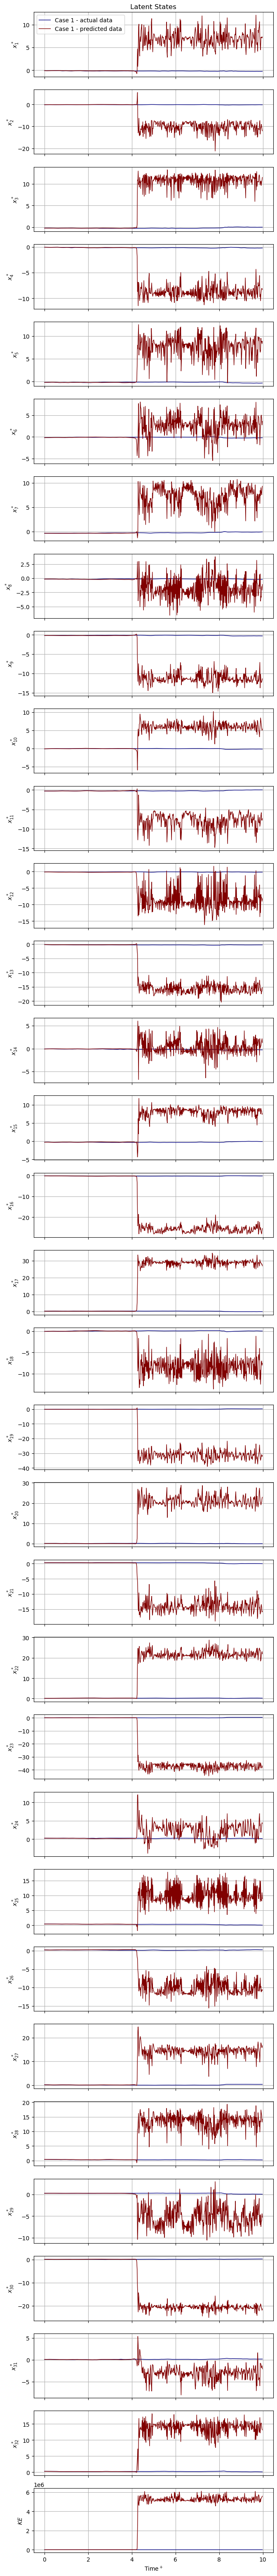


2.1775


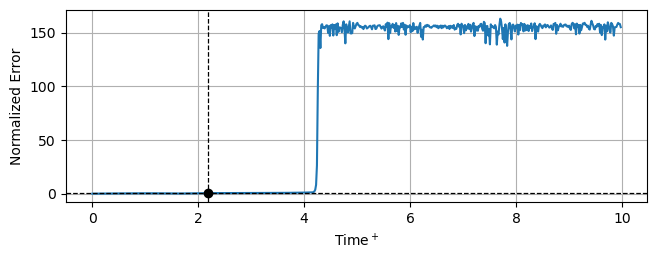

In [38]:
print('data_to_consider : ', data_to_consider)

data_in = data_rnn_input
data_out = data_rnn_output

data_idx = np.arange(data_in.shape[0])
np.random.shuffle(data_idx)
data_idx = data_idx[0]
# data_idx = 11269
for i in range(len(rnn_data_boundary_idx_arr)):
    if data_idx < rnn_data_boundary_idx_arr[i]:
        case_idx = i
        break
lyap_time = (1/0.065)#lyapunov_time_arr[case_idx]

print('case {}, data_idx : {}'.format(case_idx+1, data_idx))

# data_in = data_in[data_idx]
data_out = data_out[data_idx]
# data_out = rescale_data(data_out, normalization_arr)
data_out = invert_normalization(data_out, normalization_arr)

# prediction = rnn_net.predict(data_in[data_idx:data_idx+1, :, :], batch_size=1)
prediction = rnn_net.call(data_in[data_idx:data_idx+1, :, :], training=False).numpy()
# prediction = rnn_net.call(data_in[data_idx:data_idx+1, :, :], training=False)
prediction = invert_normalization(prediction, normalization_arr)

#-- computing KE --#
KE_og = ae_net.decoder_net.predict(data_out.reshape(data_out.shape[0], 2, 4, 4))
KE_pred = ae_net.decoder_net.predict(prediction[0, :, :].reshape(prediction.shape[1], 2, 4, 4))

KE_og = np.sum(KE_og.reshape(KE_og.shape[0], -1)**2, axis=-1)
KE_pred = np.sum(KE_pred.reshape(KE_pred.shape[0], -1)**2, axis=-1)
#-- KE computed --#

n = 1
num_latent_states = data_out.shape[-1]
N = data_out.shape[0]

num_cols = 1
num_rows = n*num_latent_states

ax_ylabels = ['$x^*_{' +str(i)+'}$' for i in range(1, num_latent_states+1)]

fig, ax = plt.subplots(num_latent_states+1, 1, sharex=True, figsize=(7.5*num_cols, 2.5*num_rows))
if num_latent_states == 1:
    ax = [ax]
input_time = np.arange(0, N)*dt_rnn/lyap_time

cmap = plt.get_cmap('jet')
colors = [cmap(i) for i in np.linspace(0, 1, 2*n)]

prev_idx = 0

mpl_ax_artist_list = []
for j in range(num_latent_states):
    for i in range(n):
        obj_in = ax[j].plot(input_time, data_out[:, j], linewidth=1, color=colors[2*i], label='Case {} - actual data'.format(i+1))
        obj_out = ax[j].plot(input_time, prediction[0, :, j], linewidth=1, color=colors[2*i+1], label='Case {} - predicted data'.format(i+1))
        mpl_ax_artist_list.append(obj_in[0])
        mpl_ax_artist_list.append(obj_out[0])
    ax[j].set_ylabel(ax_ylabels[j])
    # if xlim is not None:
    #     ax[j].set_xlim(xlim)
    # if ylim is not None:
    #     ax[j].set_ylim(ylim)
    ax[j].grid(True)
    ax[j].set_axisbelow(True)

ax[-1].plot(input_time, KE_og, linewidth=1, color=colors[0], label='Case {} - actual KE'.format(i+1))
ax[-1].plot(input_time, KE_pred, linewidth=1, color=colors[1], label='Case {} - predicted KE'.format(i+1))
ax[-1].set_ylabel('$KE$')
ax[-1].grid(True)
ax[-1].set_axisbelow(True)

ax[-1].set_xlabel('Time$^+$')

max_rows = 10
max_rows = float(max_rows)
ncols = int(np.ceil(len(rnn_data_boundary_idx_arr) / max_rows))
ax[0].legend(
    loc='best',
    ncol=ncols,
)
ax[0].set_title(r'Latent States', size=12)
plt.show()
# plt.savefig('AR-GRU.png', dpi=300, bbox_inches='tight')
print('')

### Error and prediction horizon
# error = np.linalg.norm(data_out[:, :] - prediction[0, :, :], axis=1)
error = (data_out[:, :] - prediction[0, :, :])**2
# error /= norm_sq_time_average(data_out)**0.5
error = np.mean(np.divide(error, time_stddev_AEproducedlatentstates**2), axis=1)**0.5

# print(norm_sq_time_average(data_out)**0.5)

fig2, ax2 = plt.subplots(1, 1, figsize=(7.5, 2.5))
ax2.plot(input_time, error)
ax2.grid(True)
ax2.set_axisbelow(True)
ax2.set_xlabel('Time$^+$')
ax2.set_ylabel('Normalized Error')

error_threshold = 0.5

predhor_idx = np.where(error >= error_threshold)[0][0]
# predhor_idx = np.where(error <= error_threshold)[0]

ax2.plot(input_time[predhor_idx], error[predhor_idx], 'o', color='k')
ax2.axhline(error[predhor_idx], linewidth=0.9, linestyle='--', color='k')
ax2.axvline(input_time[predhor_idx], linewidth=0.9, linestyle='--', color='k')

prediction_horizon = predhor_idx*dt_rnn/lyap_time
print(prediction_horizon)

plt.show()

In [34]:
data_in.shape

(60, 62, 32)

In [ ]:
# rnn_net.postWout.individual_weights

In [ ]:
# f = h5py.File(wt_file, 'r')

In [ ]:
# f.keys()

In [ ]:
# f['ESN_net_postWout'].keys()

In [ ]:
# np.array(f['ESN_net_postWout']['individual_weights'])

In [ ]:
# f.close()

In [ ]:
data_in_og = data_rnn_input
data_out_og = data_rnn_output

num_runs = 100
num_runs = np.min([num_runs, data_in_og.shape[0]])
print('num_runs :', num_runs)
error_threshold = 0.5

# data_idx_arr = np.arange(data_in_og.shape[0])
# np.random.shuffle(data_idx_arr)
data_idx_arr = np.linspace(0, data_in_og.shape[0]-1, num_runs, dtype=np.int32)

prediction_horizon_arr = np.empty(shape=num_runs)

# prediction = rnn_net.predict(data_in_og[data_idx_arr[0:num_runs], :, :])
prediction = rnn_net(data_in_og[data_idx_arr[0:num_runs], :, :], training=False).numpy()
prediction = invert_normalization(prediction, normalization_arr)

for i in range(num_runs):
    data_idx = data_idx_arr[i]

    for j in range(len(rnn_data_boundary_idx_arr)):
        if data_idx < rnn_data_boundary_idx_arr[j]:
            case_idx = j
            break
    lyap_time = (1/0.065)#lyapunov_time_arr[j]
    
    data_out = data_out_og[data_idx]
#     data_out = rescale_data(data_out, normalization_arr)
    data_out = invert_normalization(data_out, normalization_arr)

    # prediction = rnn_net.predict(data_in_og[data_idx:data_idx+1, :, :])

    ### Error and prediction horizon
    # error = np.linalg.norm(data_out[:, :] - prediction[i, :, :], axis=1)
    error = (data_out[:, :] - prediction[i, :, :])**2
    # error /= norm_sq_time_average(data_out)**0.5
    error = np.mean(np.divide(error, time_stddev_AEproducedlatentstates**2), axis=1)**0.5

    predhor_idx = np.where(error >= error_threshold)[0]
    if predhor_idx.shape[0] == 0:
        predhor_idx = error.shape[0]
    else:
        predhor_idx = predhor_idx[0]

    prediction_horizon_arr[i] = predhor_idx*dt_rnn/lyap_time

median_idx = int(np.round(0.5*num_runs-1))
quartile_1_idx = int(np.round(0.25*num_runs-1))
quartile_3_idx = int(np.round(0.75*num_runs-1))

prediction_horizon_arr.sort()

median = prediction_horizon_arr[median_idx]
quartile_1 = prediction_horizon_arr[quartile_1_idx]
quartile_3 = prediction_horizon_arr[quartile_3_idx]
IQR = quartile_3 - quartile_1

prediction_horizon = np.mean(prediction_horizon_arr)
stddev_ph = np.std(prediction_horizon_arr)

s = 'num_runs : {}, error_threshold = {}\n'.format(num_runs, error_threshold)
s += 'prediction_horizon : {}, median : {}\n'.format(prediction_horizon, median)
s += 'ph_min : {}, ph_max : {}\n'.format(prediction_horizon_arr.min(), prediction_horizon_arr.max())
s += 'stddev : {}, IQR : {}\n'.format(stddev_ph, IQR)
s += '1st quartile : {}, 3rd quartile : {}'.format(quartile_1, quartile_3)

print(dir_name_rnn[-7:])
print('\n'+s)

In [ ]:
# with h5py.File(wt_file, 'r') as fl:
#     Wout_saved = np.array(fl['ESN_net_Wout']['kernel'])
    
#     ESN_cell_Wres = fl['ESN_cell_Wres']
#     Wres_this_cell = ESN_cell_Wres["cell_{}".format(0)]
    
#     Wres_kernel_sparse_values = np.array(Wres_this_cell["kernel_values"])
#     Wres_kernel_sparse_indices = np.array(Wres_this_cell["kernel_indices"])
#     Wres_kernel = tf.sparse.SparseTensor(
#         indices=Wres_kernel_sparse_indices,
#         values=Wres_kernel_sparse_values,
#         dense_shape=[rnn_net.ESN_layers_units[0], rnn_net.ESN_layers_units[0]])
#     Wres_kernel = tf.sparse.to_dense(Wres_kernel)
#     Wres_kernel = Wres_kernel.numpy()

In [ ]:
# Wout_rnn = rnn_net.Wout.kernel.numpy()

In [ ]:
# a = Wout_saved - Wout_rnn

In [ ]:
# np.sum(a == 0)

In [ ]:
# Wres_rnn = rnn_net.rnn_list[0].cell.Wres.kernel.numpy() * rnn_net.rnn_list[0].cell.rho_res.numpy()

In [ ]:
# b = Wres_kernel - Wres_rnn

In [ ]:
# np.sum(b==0)

In [ ]:
savefig_fname = 'pre-ARtraining'+'_'+data_to_consider+'data'
# savefig_fname = 'post-ARtraining'
# savefig_fname = None
# nbins = np.min([100, data_in.shape[0]//8])

In [ ]:
if savefig_fname != None:
    npsavedata_fname = '/prediction_horizons-'+data_to_consider+'data'
    np.savez(
        dir_name_rnn+npsavedata_fname,
        prediction_horizon_arr=prediction_horizon_arr,
        error_threshold=error_threshold,
    )
    
    with open(dir_name_rnn+npsavedata_fname+'--statistics.txt', 'w') as fl:
        fl.write(s)

In [ ]:
fig, ax = plt.subplots()

bin_width = 0.05
bin_begin = 0
bin_end = bin_width*np.round((np.max(prediction_horizon_arr)+0.5*bin_width)//bin_width)
nbins = int(np.round(bin_end/bin_width))

ax.hist(prediction_horizon_arr, bins=nbins, range = [bin_begin, bin_end], density=True)
ax.axvline(prediction_horizon, linewidth=0.9, linestyle='--', color='k')

ax.set_xlabel('Prediction Horizon (Lyapunov times)')
ax.set_ylabel('PDF')

ax.grid(True)
# ax.set_axisbelow(True)

ax.text(
    0.01 + ax.transAxes.inverted().transform(ax.transData.transform([prediction_horizon, 0]))[0],
    0.8,
    'mean',
    rotation=90,
    verticalalignment='bottom',
    horizontalalignment='left',
    bbox=dict(facecolor=np.array([255,255,153])/255, alpha=1, boxstyle='square,pad=0.2'),
    transform=ax.transAxes
)

text_xy = [0.95, 0.95]
ax.text(
    text_xy[0],
    text_xy[1],
    'mean : {:.4f}\nmax : {:.4f}\nmin : {:.4f}\nstddev : {:.4f}'.format(
        prediction_horizon,
        np.max(prediction_horizon_arr),
        np.min(prediction_horizon_arr),
        stddev_ph,
    ),
    transform=ax.transAxes,
    bbox=dict(
        boxstyle="round",
        ec=(0.6, 0.6, 1),
        fc=(0.9, 0.9, 1),
    ),
    # bbox=dict(facecolor='C0', alpha=0.5, boxstyle='round,pad=0.2'),
    horizontalalignment='right',
    verticalalignment='top'
)

ax.set_title('nbins = {}'.format(nbins))

if savefig_fname is not None:
    fig.savefig(dir_name_rnn+dir_sep+'plots'+dir_sep+savefig_fname+'.png', dpi=300, bbox_inches='tight')
    fig.clear()
    plt.close()
else:
    plt.show()
    print('')

In [ ]:
#